Previously, we saw that there was no requirement for the latent space to be continu‐
ous—even if the point (–2, 2) decodes to a well-formed image of a sandal, there’s no
requirement for (–2.1, 2.1) to look similar. Now, since we are sampling a random
point from an area around z_mean, the decoder must ensure that all points in the
same neighborhood produce very similar images when decoded, so that the recon‐
struction loss remains small. This is a very nice property that ensures that even when
we choose a point in the latent space that has never been seen by the decoder, it is
likely to decode to an image that is well formed.

First, we need to create a new type of Sampling layer that will allow us to sample from
the distribution defined by z_mean and z_log_var

In [ ]:
!pip install notebooks

ERROR: Could not find a version that satisfies the requirement notebooks (from versions: none)
ERROR: No matching distribution found for notebooks


In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [ ]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 2s 0us/step


In [ ]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

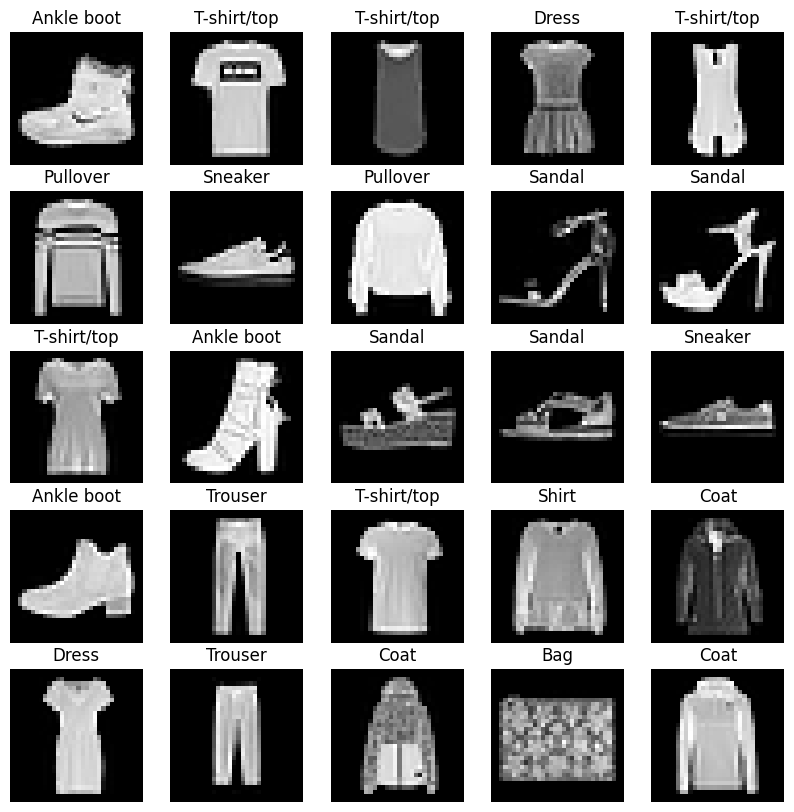

In [ ]:
import matplotlib.pyplot as plt
# Define the class names for better visualization
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Display some sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')

plt.show()

You can create new layers in Keras by subclassing the abstract Layer class and defin‐
ing the call method, which describes how a tensor is transformed by the layer.
For example, in the variational autoencoder, we can create a Sampling layer that can
handle the sampling of z from a normal distribution with parameters defined by
z_mean and z_log_var.
This is useful when you want to apply a transformation to a tensor that isn’t already
included as one of the out-of-the-box Keras layer types.


Rather than sample directly from a normal distribution with parameters z_mean and
z_log_var, we can sample epsilon from a standard normal and then manually adjust
the sample to have the correct mean and variance.
This is known as the reparameterization trick, and it’s important as it means gradients
can backpropagate freely through the layer. By keeping all of the randomness of the
layer contained within the variable epsilon, the partial derivative of the layer output
with respect to its input can be shown to be deterministic (i.e., independent of the
random ep

In [ ]:
class Sampling(layers.Layer):
 def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!
x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

KL divergence is a way of measuring how much one probability distribution differs
from another. In a VAE, we want to measure how much our normal distribution with
parameters z_mean and z_log_var differs from a standard normal distribution. In
this special case, it can be shown that the KL divergence has the following closed
form:


kl_loss = -0.5 * sum(1 + z_log_var - z_mean ^ 2 - exp(z_log_var))

In the original VAE paper, the loss function for a VAE was simply the addition of the
reconstruction loss and the KL divergence loss term. A variant on this (the β-VAE)
includes a factor that weights the KL divergence to ensure that it is well balanced with
the reconstruction loss. If we weight the reconstruction loss too heavily, the KL loss
will not have the desired regulatory effect and we will see the same problems that we
experienced with the plain autoencoder. If the KL divergence term is weighted too
heavily, the KL divergence loss will dominate and the reconstructed images will be
poor. This weighting term is one of the parameters to tune when you’re training your
VAE.

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA* losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

In [ ]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
vae.fit(
    x_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/10
599/600 [============================>.] - ETA: 0s - total_loss: 159.3866 - reconstruction_loss: 154.9457 - kl_loss: 4.4409

600/600 [==============================] - 17s 16ms/step - total_loss: 159.3499 - reconstruction_loss: 154.9082 - kl_loss: 4.4416 - val_loss: 141.6024 - val_reconstruction_loss: 136.6868 - val_kl_loss: 4.9157
Epoch 2/10
599/600 [============================>.] - ETA: 0s - total_loss: 135.9370 - reconstruction_loss: 131.0833 - kl_loss: 4.8536

600/600 [==============================] - 6s 11ms/step - total_loss: 135.9346 - reconstruction_loss: 131.0806 - kl_loss: 4.8540 - val_loss: 137.6385 - val_reconstruction_loss: 132.5831 - val_kl_loss: 5.0554
Epoch 3/10
595/600 [============================>.] - ETA: 0s - total_loss: 134.0980 - reconstruction_loss: 129.1846 - kl_loss: 4.9134

600/600 [==============================] - 7s 11ms/step - total_loss: 134.1236 - reconstruction_loss: 129.2092 - kl_loss: 4.9144 - val_loss: 137.1936 - val_reconstruction_loss: 132.0433 - val_kl_loss: 5.1503
Epoch 4/10
595/600 [============================>.] - ETA: 0s - total_loss: 133.2314 - reconstruction_loss: 128.2713 - kl_loss: 4.9600

600/600 [==============================] - 6s 9ms/step - total_loss: 133.2525 - reconstruction_loss: 128.2915 - kl_loss: 4.9609 - val_loss: 136.1014 - val_reconstruction_loss: 130.7230 - val_kl_loss: 5.3784
Epoch 5/10
599/600 [============================>.] - ETA: 0s - total_loss: 132.7165 - reconstruction_loss: 127.6975 - kl_loss: 5.0189

600/600 [==============================] - 6s 10ms/step - total_loss: 132.7165 - reconstruction_loss: 127.6976 - kl_loss: 5.0188 - val_loss: 135.1922 - val_reconstruction_loss: 130.0148 - val_kl_loss: 5.1774
Epoch 6/10
595/600 [============================>.] - ETA: 0s - total_loss: 132.3705 - reconstruction_loss: 127.3086 - kl_loss: 5.0619

600/600 [==============================] - 7s 12ms/step - total_loss: 132.3389 - reconstruction_loss: 127.2754 - kl_loss: 5.0634 - val_loss: 135.5493 - val_reconstruction_loss: 130.2735 - val_kl_loss: 5.2759
Epoch 7/10
598/600 [============================>.] - ETA: 0s - total_loss: 131.9654 - reconstruction_loss: 126.8603 - kl_loss: 5.1050

600/600 [==============================] - 6s 10ms/step - total_loss: 131.9682 - reconstruction_loss: 126.8633 - kl_loss: 5.1049 - val_loss: 134.8030 - val_reconstruction_loss: 129.5773 - val_kl_loss: 5.2256
Epoch 8/10
598/600 [============================>.] - ETA: 0s - total_loss: 131.7328 - reconstruction_loss: 126.6206 - kl_loss: 5.1122

600/600 [==============================] - 7s 11ms/step - total_loss: 131.7350 - reconstruction_loss: 126.6226 - kl_loss: 5.1123 - val_loss: 134.9465 - val_reconstruction_loss: 129.5079 - val_kl_loss: 5.4386
Epoch 9/10
597/600 [============================>.] - ETA: 0s - total_loss: 131.4585 - reconstruction_loss: 126.3068 - kl_loss: 5.1517

600/600 [==============================] - 7s 12ms/step - total_loss: 131.4650 - reconstruction_loss: 126.3143 - kl_loss: 5.1507 - val_loss: 134.6022 - val_reconstruction_loss: 129.5269 - val_kl_loss: 5.0753
Epoch 10/10
596/600 [============================>.] - ETA: 0s - total_loss: 131.2621 - reconstruction_loss: 126.0919 - kl_loss: 5.1703

600/600 [==============================] - 7s 11ms/step - total_loss: 131.2561 - reconstruction_loss: 126.0858 - kl_loss: 5.1703 - val_loss: 134.7809 - val_reconstruction_loss: 129.5224 - val_kl_loss: 5.2585


In [ ]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

In [ ]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 0s 3ms/step
Example real clothing items


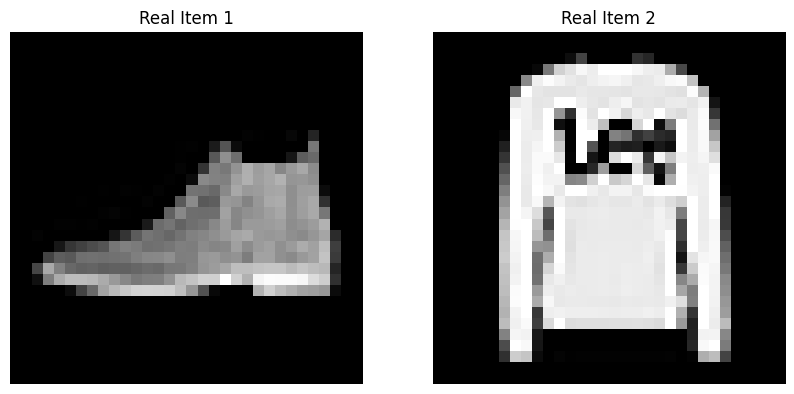

Reconstructions


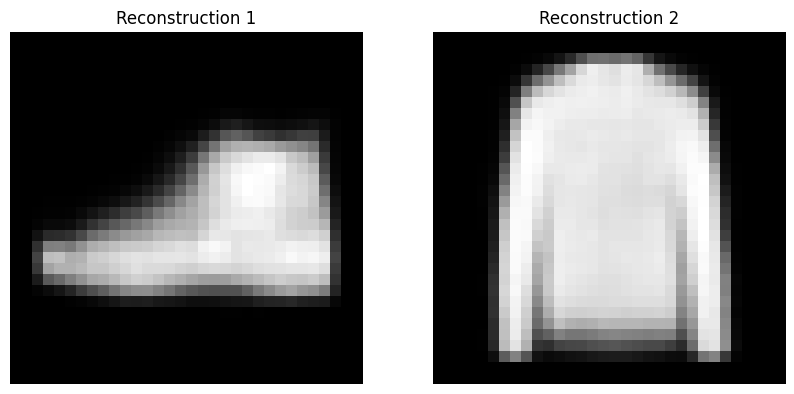

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create autoencoder predictions
z_mean, z_log_var, reconstructions = vae.predict(example_images)

# Display example real clothing items
print("Example real clothing items")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, ax in enumerate(axes):
    ax.imshow(example_images[i].reshape(32, 32), cmap='gray')  # Change reshape dimensions
    ax.axis('off')
    ax.set_title(f'Real Item {i + 1}')

plt.show()

# Display reconstructions
print("Reconstructions")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, ax in enumerate(axes):
    ax.imshow(reconstructions[i].reshape(32, 32), cmap='gray')  # Change reshape dimensions
    ax.axis('off')
    ax.set_title(f'Reconstruction {i + 1}')

plt.show()


In [ ]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [ ]:
# Some examples of the embeddings
print(z[:10])

[[ 0.47497106  1.0571008 ]
 [-1.1371579  -0.235269  ]
 [-0.45635292 -2.6823192 ]
 [ 0.8688101  -2.1597357 ]
 [-0.27897835  0.10300007]
 [-0.7571217  -2.0379865 ]
 [ 1.183706   -0.09587855]
 [ 0.1971963  -0.11428465]
 [ 1.9032875   2.7031808 ]
 [ 0.03759129  2.1830084 ]]


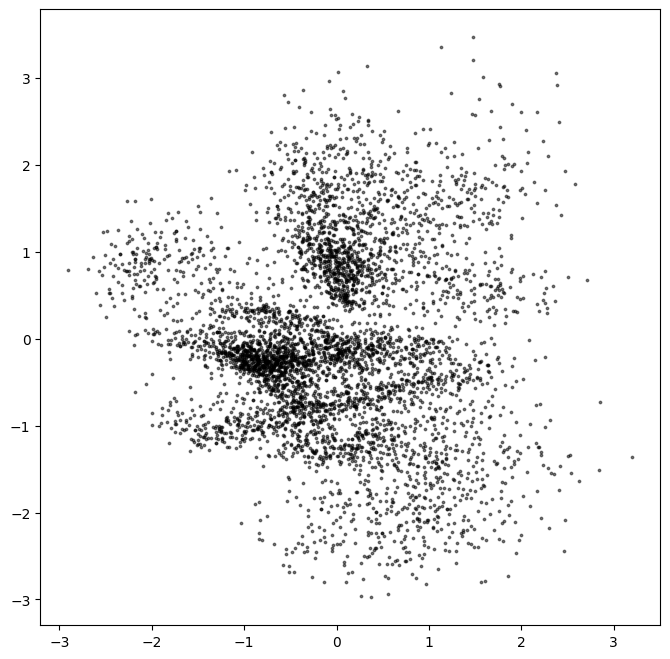

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

Firstly, the KL divergence loss term ensures that the z_mean and z_log_var values of
the encoded images never stray too far from a standard normal distribution. Sec‐
ondly, there are not so many poorly formed images as the latent space is now much
more continuous, due to fact that the encoder is now stochastic, rather than
deterministic.


In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 281ms/step


In [ ]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

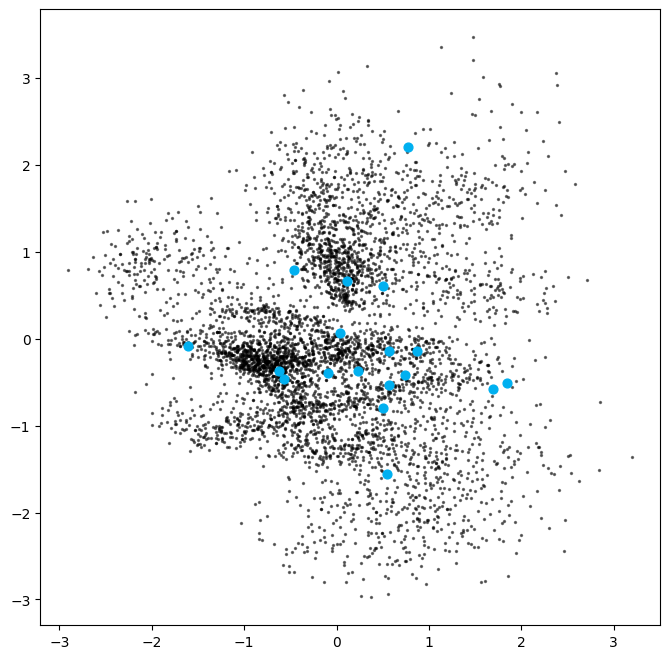

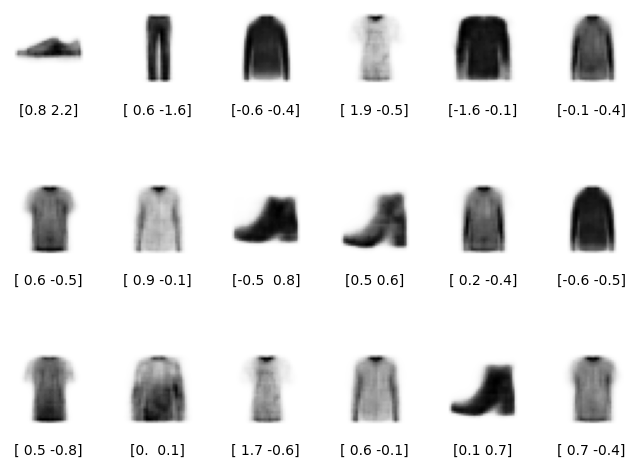

In [ ]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

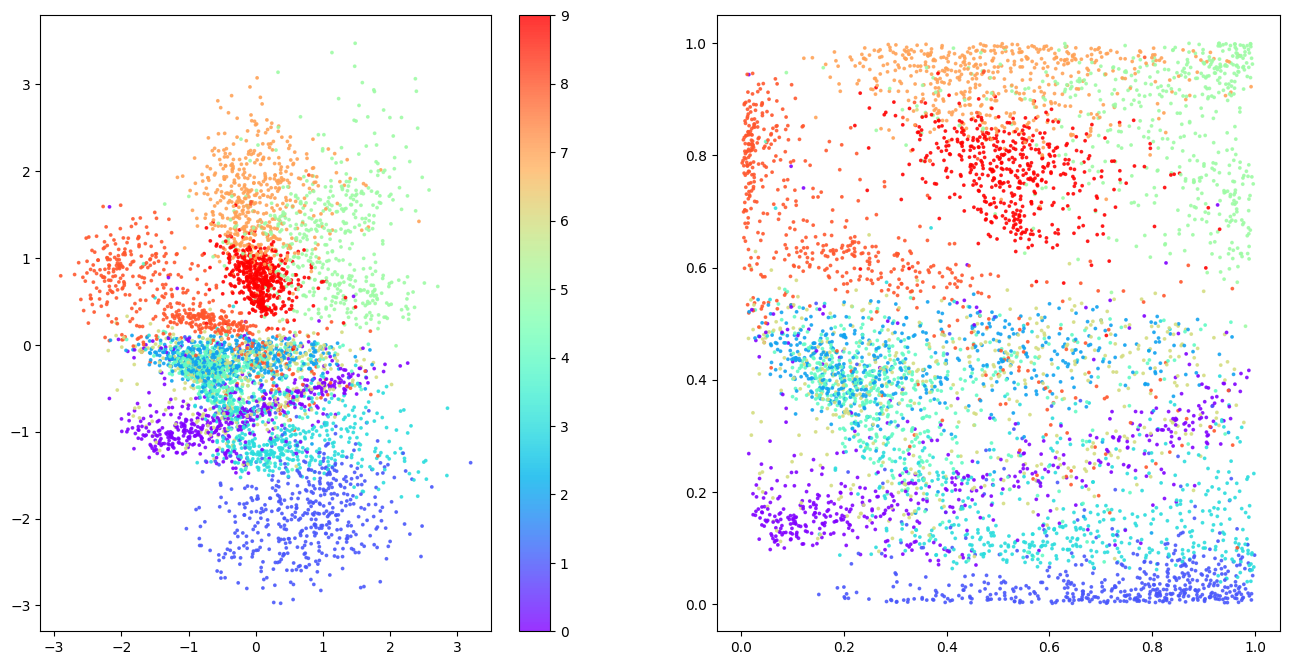

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

Finally, by coloring points in the latent space by clothing type, we can
see that there is no preferential treatment of any one type. The righthand plot shows
the space transformed into p-values—we can see that each color is approximately
equally represented. Again, it’s important to remember that the labels were not used
at all during training; the VAE has learned the various forms of clothing by itself in
order to help minimize reconstruction loss.

8/8 [==============================] - 0s 27ms/step


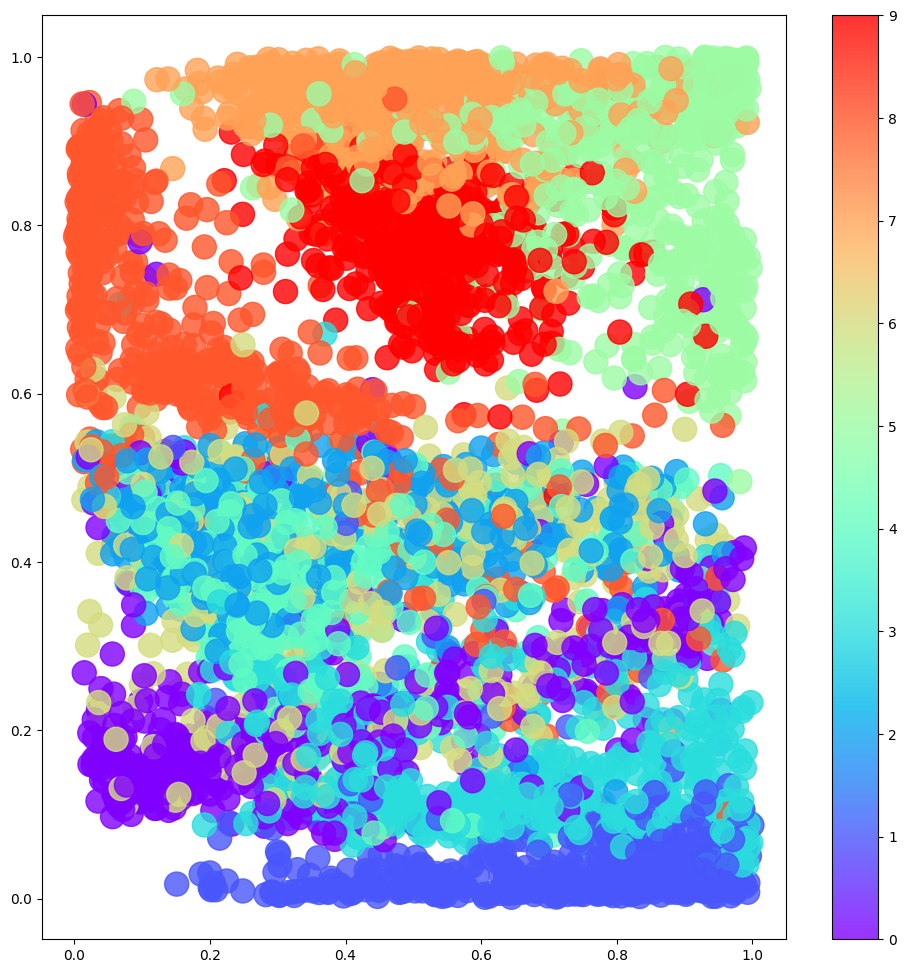

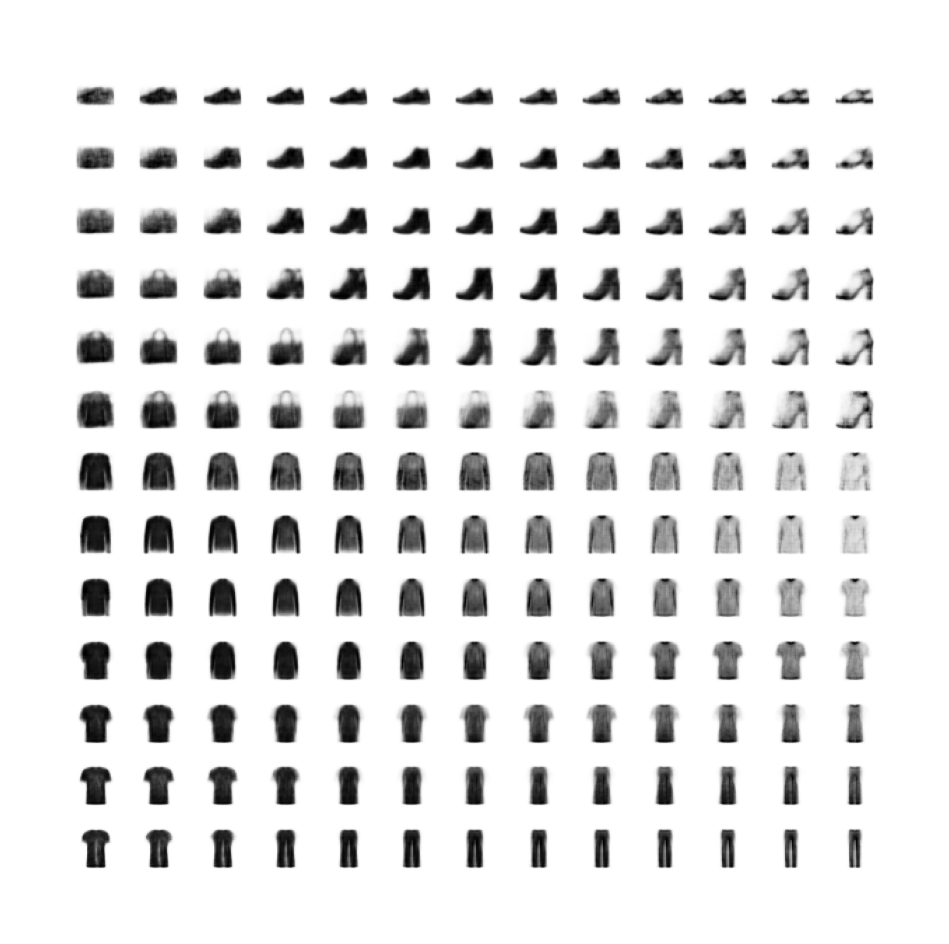

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")